# LSTM

In [3]:
import numpy as np
import tensorflow as tf
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, Normalizer
import seaborn as sns

In [27]:
df = pd.read_csv("../data/training_data.csv")
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,d_volatility,VIX
1242,2021-12-08,4690.859863,4705.060059,4674.520020,4701.209961,4701.209961,3061550000,0.006511,19.90
1243,2021-12-09,4691.000000,4695.259766,4665.979980,4667.450195,4667.450195,2851660000,0.006242,21.58
1244,2021-12-10,4687.640137,4713.569824,4670.240234,4712.020020,4712.020020,2858310000,0.009243,18.69
1245,2021-12-13,4710.299805,4710.299805,4667.600098,4668.970215,4668.970215,3322050000,0.009065,20.31
1246,2021-12-14,4642.990234,4660.470215,4606.520020,4634.089844,4634.089844,3292740000,0.011620,21.89


In [5]:
#Separate dates for future plotting
train_dates = pd.to_datetime(df['Date'])
print(train_dates.tail(15)) #Check last few dates. 

1232   2021-11-23
1233   2021-11-24
1234   2021-11-26
1235   2021-11-29
1236   2021-11-30
1237   2021-12-01
1238   2021-12-02
1239   2021-12-03
1240   2021-12-06
1241   2021-12-07
1242   2021-12-08
1243   2021-12-09
1244   2021-12-10
1245   2021-12-13
1246   2021-12-14
Name: Date, dtype: datetime64[ns]


In [36]:
#Variables for training
cols = list(df)[5:6]
#Date and volume columns are not used in training. 
print(cols) 
df_for_training = df[cols].astype(float)

['Adj Close']


Normalizamos los datos

In [37]:
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

### As required for LSTM networks, we require to reshape an input data into n_samples x timesteps x n_features. 
In this example, the n_features is 5. We will make timesteps = 14 (past days data used for training). 

In [38]:
#Empty lists to be populated using formatted training data
trainX = []
trainY = []

n_future = 16  # Number of days we want to look into the future based on the past days.
n_past = 32  # Number of past days we want to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In my example, my df_for_training_scaled has a shape (12823, 5)
#12823 refers to the number of data points and 5 refers to the columns (multi-variables).
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    trainX.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

trainX, trainY = np.array(trainX), np.array(trainY)

print('trainX shape == {}.'.format(trainX.shape))
print('trainY shape == {}.'.format(trainY.shape))

trainX shape == (1200, 32, 1).
trainY shape == (1200, 1).


Modelo

In [39]:
def modelo_lstm(trainX,trainY,neuronas, capas, epocas, batch_size,validation_split):

    csv_logger = tf.keras.callbacks.CSVLogger('training.log', separator=',', append=False)

    model = tf.keras.models.Sequential()
    #Entrada
    model.add(tf.keras.layers.LSTM(neuronas ,activation='tanh', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
    model.add(tf.keras.layers.Dropout(0.2)) # regularizacion en las conexiones de entrada
    #second LSTM
    for i in range(capas):
        model.add(tf.keras.layers.LSTM(units=int(neuronas/2), activation='tanh', return_sequences = True))
        model.add(tf.keras.layers.Dropout(0.2))
    # Salida
    model.add(tf.keras.layers.Dense(trainY.shape[1]))
    model.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError())
    model.summary()

    #definir "early stopping" la loss de validacion no mejora en X épocas
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=20,  #numero de epocas sin mejora
                                                      restore_best_weights = True)

    history = model.fit(trainX, trainY, epochs=epocas, batch_size=batch_size, validation_split=validation_split, verbose=1, callbacks=[early_stopping, csv_logger])

    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.ylabel("Error")
    plt.xlabel("Epocas")
    plt.legend()
    return model
    

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_11 (LSTM)              (None, 32, 64)            16896     
                                                                 
 dropout_11 (Dropout)        (None, 32, 64)            0         
                                                                 
 lstm_12 (LSTM)              (None, 32, 32)            12416     
                                                                 
 dropout_12 (Dropout)        (None, 32, 32)            0         
                                                                 
 dense_5 (Dense)             (None, 32, 1)             33        
                                                                 
Total params: 29,345
Trainable params: 29,345
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200


2022-01-24 21:08:53.807551: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-24 21:08:54.038037: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-24 21:08:54.100575: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-24 21:08:54.185173: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


  3/135 [..............................] - ETA: 4s - loss: 0.4051  

2022-01-24 21:08:54.301908: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


134/135 [============================>.] - ETA: 0s - loss: 0.1375

2022-01-24 21:08:57.391745: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-24 21:08:57.461340: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-24 21:08:57.510955: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


135/135 [==============================] - 4s 24ms/step - loss: 0.1375 - val_loss: 0.2138
Epoch 2/200
135/135 [==============================] - 3s 22ms/step - loss: 0.0997 - val_loss: 0.2466
Epoch 3/200
135/135 [==============================] - 3s 22ms/step - loss: 0.1139 - val_loss: 0.1493
Epoch 4/200
135/135 [==============================] - 3s 21ms/step - loss: 0.1443 - val_loss: 0.1089
Epoch 5/200
135/135 [==============================] - 3s 22ms/step - loss: 0.1176 - val_loss: 0.1991
Epoch 6/200
135/135 [==============================] - 3s 21ms/step - loss: 0.1210 - val_loss: 0.1294
Epoch 7/200
135/135 [==============================] - 3s 22ms/step - loss: 0.1177 - val_loss: 0.2120
Epoch 8/200
135/135 [==============================] - 3s 21ms/step - loss: 0.1206 - val_loss: 0.1308
Epoch 9/200
135/135 [==============================] - 3s 22ms/step - loss: 0.1218 - val_loss: 0.1872
Epoch 10/200
135/135 [==============================] - 3s 22ms/step - loss: 0.1165 - val_loss

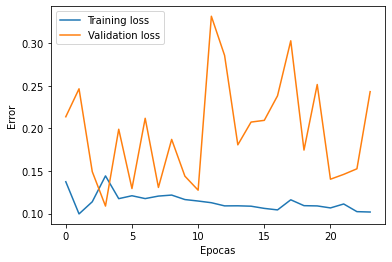

In [46]:
modelo = modelo_lstm(trainX, trainY, 64, capas=1,epocas=200, batch_size=8,validation_split=0.1)
# 64 neuronas, 1 capa, 36 epocas, batch_size=8, val_split= 0.1

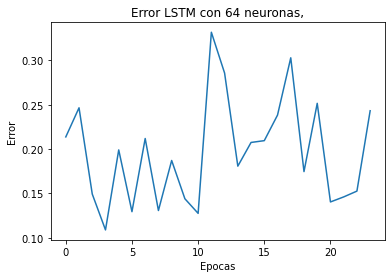

In [47]:
neuronas = 64
registro = pd.read_csv('training.log', sep=",")
plt.plot(registro["epoch"].values, registro["val_loss"].values)
plt.title("Error LSTM con %i neuronas," % (neuronas))
plt.ylabel("Error")
plt.xlabel("Epocas")
plt.show()

In [48]:
registro.val_loss.min()

0.1088806837797164

Predict

In [49]:

close_data = df['Adj Close'].values
close_data = close_data.reshape((-1,1))
close_data = close_data.reshape((-1))

def predict(num_prediction, model):
    prediction_list = close_data[-n_past:]
    
    for _ in range(num_prediction):
        x = prediction_list[-n_past:]
        x = x.reshape((1, n_past, 1))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[n_past-1:]
        
    return prediction_list
    
def predict_dates(num_prediction):
    last_date = df['Date'].values[-1]
    prediction_dates = pd.date_range(last_date, periods=num_prediction+1).tolist()
    return prediction_dates

num_prediction = 30
forecast = predict(num_prediction, modelo)
forecast_dates = predict_dates(num_prediction)

2022-01-24 21:10:57.220534: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-24 21:10:57.293951: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2022-01-24 21:10:57.837609: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


In [52]:
predict_df = pd.DataFrame({'Date':forecast_dates, 'predict_value': forecast})

In [59]:
scaler.inverse_transform(forecast[1:].reshape(-1,1))


array([[4079.29095958],
       [4079.29018731],
       [4079.28833388],
       [4079.28516759],
       [4079.28308247],
       [4079.28122903],
       [4079.28076567],
       [4079.28261911],
       [4079.28663489],
       [4079.28640321],
       [4079.28277356],
       [4079.28277356],
       [4079.28092012],
       [4079.28223298],
       [4079.28045676],
       [4079.2811518 ],
       [4079.28285079],
       [4079.2820013 ],
       [4079.2808429 ],
       [4079.2921952 ],
       [4079.28570817],
       [4079.29512982],
       [4079.30092181],
       [4079.29412587],
       [4079.29821888],
       [4079.29250411],
       [4079.2823102 ],
       [4079.28092012],
       [4079.28447255],
       [4079.27976172]])

predict_df